# Data Analysis and Visualization of Time to Target with Tremor Identification

This code was developed to analyze data and generate figures for "Evaluating Mouse Control and Usability Patterns Across Tremor and Non-Tremor Populations"

### Loading necessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Processing Functions

In [3]:
# Define FFT
def simpleFFT(fs, signal):
    N = len(signal)
    f = fs / N * np.arange(N)
    F_signal = np.fft.fft(signal) / N
    freqs = f[:N // 2]
    f_amp = np.abs(F_signal[:N // 2])
    return freqs, f_amp

## Calculate Spectrums

In [4]:
# tremor status of participants
tremors = pd.read_csv('../survey analysis/survey_results_text.csv', skiprows=1, header=0)
tremors = tremors[tremors['participant_ID']!='SURVEY TEST']
tremors = tremors[['participant_ID', 'tremor_level']]

In [45]:
# Create dataframe with spectrum information
spectrum_power = pd.DataFrame({'participant_ID': [], 'power': []})

for i in range(50):
    if os.path.exists("./data/TestTaker" + str(i) + ".csv"):

        # Load the data
        data = pd.read_csv(("./data/TestTaker" + str(i) + ".csv"))
        data.columns = data.columns.str.strip()

        t = data["Timestamp"].values
        Z = data["GyroZ"].values

        # Calculate the power spectrum
        fs = 1 / (t[1] - t[0])
        f, f_amp = simpleFFT(fs, Z)

        # Identify [something]
        row = pd.DataFrame({'participant_ID': ['PT' + str(i).zfill(2)], 'power': [np.sum(f_amp)/len(f_amp)]})
        # print(row)
        spectrum_power = pd.concat([spectrum_power, row], ignore_index=True)

In [46]:
# Merge the data
spectrum_power['participant_ID'] = spectrum_power['participant_ID']
participant_power = pd.merge(tremors, spectrum_power, on='participant_ID')
participant_power = participant_power.dropna()


## Spectrum Power per Participant

### Combine Data Into One DataFrame

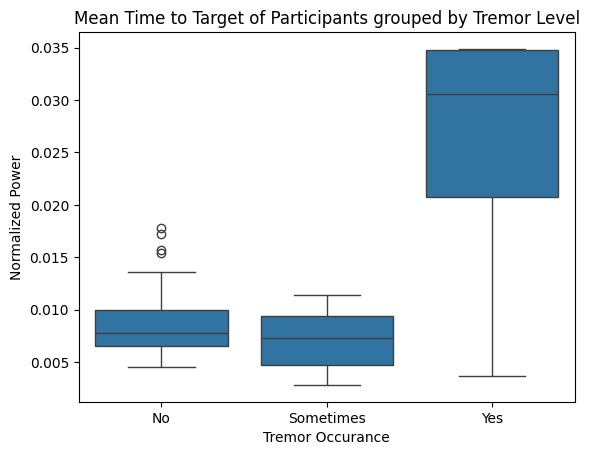

In [51]:
sns.boxplot(data=participant_power, x='tremor_level', y='power')
plt.title('Mean Time to Target of Participants grouped by Tremor Level')
plt.xlabel('Tremor Occurance')
plt.ylabel('Normalized Power')
plt.show()

In [48]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# One-way ANOVA: Score by tremor_level
anova_model = ols('power ~ C(tremor_level)', data=participant_power).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)


                   sum_sq    df          F        PR(>F)
C(tremor_level)  0.001002   2.0  19.580081  7.627530e-07
Residual         0.001151  45.0        NaN           NaN


In [49]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey’s test
tukey = pairwise_tukeyhsd(endog=participant_power['power'],
                          groups=participant_power['tremor_level'],
                          alpha=0.05)

# Print summary table
print(tukey.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
       No Sometimes  -0.0017 0.6937 -0.0068 0.0033  False
       No       Yes   0.0161    0.0  0.0097 0.0226   True
Sometimes       Yes   0.0178    0.0  0.0101 0.0255   True
---------------------------------------------------------
